<a href="https://colab.research.google.com/github/josephjwilson/cayley_graph_propagation/blob/main/Cayley_Graph_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cayley Graph Propagation

Here, is a stand-alone introduction to **Cayley Graph Propagation (CGP)** that can be implemented in any repository. This provides a quick starter guide on how to use the provided expander graphs in the form of the complete Cayley graph structure, utilising the transformations on the datasets as you wish. In particular, we will show how to use the additional virtual nodes as part of the model. Additionally, within the [Cayley Graph Propagation GitHub](https://github.com/josephjwilson/cayley_graph_propagation) I have unified the code-base so you can reproduce the multiple datasets as found in CGP

**CGP Authors**:
- [JJ Wilson](linkedin.com/in/joseph-j-wilson-swe74)
- [Maya Bechler-Speicher](https://il.linkedin.com/in/maya-bechler-speicher-815103103)
- [Petar veličković](https://petar-v.com/)


**Outline**:
- Visualise the Cayley graph transformations for both [EGP] and CGP on real-world datasets
- Understand the over-squashing phenomenon
- Train a model using CGP, including the baselines
- [Bonus] Compare CGP to a graph-rewiring technique


---

I would also like to thank the following GitHub repositories, as they were used as part of the implementation of the CGP paper:

- [OGB](https://github.com/snap-stanford/ogb)
- [FoSR](https://github.com/kedar2/FoSR)
- [GraphGym](https://github.com/snap-stanford/GraphGym)
- [PANDA](https://github.com/jeongwhanchoi/PANDA)
- [LASER](https://github.com/Fedzbar/laser-release)
- [EEML 2024: Geometric Deep Learning](https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning)

## Preliminaries: Imports and helper functions

In [7]:
!pip install -q networkx
!pip install torch==2.3.0
!pip install -q torch-geometric
!pip install primefac

import os
import torch
os.environ['TORCH'] = torch.__version__
!pip install -q pyg_lib torch_scatter torch_sparse -f https://data.pyg.org/whl/torch-${TORCH}.html

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import networkx as nx

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

from tqdm import tqdm

In [9]:
# code based on: https://jhuow.fun/posts/barbell_graph/
def one_barbell_graph(n_clique, n_path):
  clique1 = nx.complete_graph(n_clique)
  clique1_pos = nx.circular_layout(clique1)
  clique2 = nx.complete_graph(n_clique)
  clique2_mapping = {node: node + n_clique for node in clique2}
  nx.relabel_nodes(clique2, clique2_mapping, copy=False) # avoids repeated nodes
  x_diff, y_diff = 8, -1
  clique2_pos = {node: clique1_pos[node-n_clique] + (x_diff, y_diff) for node in clique2}
  path = nx.path_graph(n_path)
  path_mapping = {node: node + 2 * n_clique for node in path}
  nx.relabel_nodes(path, path_mapping, copy=False) # avoids repeated nodes
  path_nodes = list(path.nodes)
  path_half1_nodes = path_nodes[:n_path//2]
  path_half2_nodes = path_nodes[n_path//2:]
  path_dist = 0.9
  clique2_entry = n_clique + n_clique // 2
  path_half1_pos = {node: clique1_pos[0] + (path_dist + i * path_dist, 0) for i, node in enumerate(path_half1_nodes)}
  path_half2_pos = {node: clique2_pos[clique2_entry] - (path_dist + i * path_dist, 0) for i, node in enumerate(path_half2_nodes[::-1])}
  path_pos = {**path_half1_pos, **path_half2_pos}
  barbell = nx.Graph()
  barbell.add_edges_from(clique1.edges)
  barbell.add_edges_from(clique2.edges)
  barbell.add_edges_from(path.edges)
  barbell.add_edges_from([(path_half1_nodes[0], 0), (path_half2_nodes[-1], clique2_entry)])
  clique_pos = {**clique1_pos, **clique2_pos}
  barbell_pos = {**clique_pos, **path_pos}
  barbell_dict = {}
  for k,v in barbell_pos.items():
    barbell_dict[k] = {"pos":v}
  nx.set_node_attributes(barbell, barbell_dict)
  return barbell

In [10]:
# code inspired by https://github.com/lrnzgiusti/on-oversquashing
def generate_barbell_graph(m1, m2, target_label):
    """
    Generate a barbell graph.

    Args:
    - m1:
    - m2:
    - target_label

    Returns:
    - Data: Torch geometric data structure containing graph details.
    """
    barbell_graph = one_barbell_graph(m1, m2)
    nodes = 2 * m1 + m2
    # Initialize node features. The first node gets 0s, while the last gets the target label
    x = np.ones((nodes, len(target_label)))
    x[0, :] = 0.0
    x[nodes - 1, :] = target_label
    x = torch.tensor(x, dtype=torch.float32)

    edge_index = torch.tensor(list(barbell_graph.edges())).T

    # Create a mask to indicate the target node (in this case, the first node)
    mask = torch.zeros(nodes, dtype=torch.bool)
    mask[0] = 1

    # Convert the one-hot encoded target label to its corresponding class index
    y = torch.tensor([np.argmax(target_label)], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, mask=mask, y=y, pos=nx.get_node_attributes(barbell_graph, 'pos'))

In [11]:
# code based on: https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning
def draw_one_graph(ax, edges, label=None, node_emb=None, layout=None,
                   special_color=False, pos=None):
    """draw a graph with networkx based on adjacency matrix (edges)
    graph labels could be displayed as a title for each graph
    node_emb could be displayed in colors
    """
    graph = nx.Graph()
    edges = zip(edges[0], edges[1])
    graph.add_edges_from(edges)
    if layout == 'custom':
      node_pos = pos
    elif layout == 'tree':
      node_pos=nx.nx_agraph.graphviz_layout(graph, prog='dot')
    else:
      node_pos = layout(graph)
    #add colors according to node embeding
    if (node_emb is not None) or special_color:
        color_map = []
        node_list = [node[0] for node in graph.nodes(data = True)]
        for i,node in enumerate(node_list):
            #just ignore this branch
            if special_color:
                if len(node_list) == 3:
                    crt_color = (1,0,0)
                elif len(node_list) == 5:
                    crt_color = (0,1,0)
                elif len(node_list) == 4:
                    crt_color = (1,1,0)
                else:
                  special_list = [(1,0,0)] * 3 + [(0,1,0)] * 5 + [(1,1,0)] * 4
                  crt_color = special_list[i]
            else:
                crt_node_emb = node_emb[node]
                #map float number (node embeding) to a color
                crt_color = cm.gist_rainbow(crt_node_emb, bytes=True)
                crt_color = (crt_color[0]/255.0, crt_color[1]/255.0, crt_color[2]/255.0, crt_color[3]/255.0)
            color_map.append(crt_color)

        nx.draw_networkx_nodes(graph,node_pos, node_color=color_map,
                        nodelist = node_list, ax=ax)
        nx.draw_networkx_edges(graph, node_pos, ax=ax)
        nx.draw_networkx_labels(graph,node_pos, ax=ax)
    else:
        nx.draw_networkx(graph, node_pos, ax=ax)

In [12]:
# code based on: https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning
def gallery(graphs, labels=None, node_emb=None, special_color=False, max_graphs=4, max_fig_size=(40, 10), layout=nx.layout.kamada_kawai_layout):
    ''' Draw multiple graphs as a gallery
    Args:
      graphs: torch_geometrics.dataset object/ List of Graph objects
      labels: num_graphs
      node_emb: num_graphs* [num_nodes x num_ch]
      max_graphs: maximum graphs display
    '''
    num_graphs = min(len(graphs), max_graphs)
    ff, axes = plt.subplots(1, num_graphs,
                            figsize=max_fig_size,
                            subplot_kw={'xticks': [], 'yticks': []})
    if num_graphs == 1:
        axes = [axes]
    if node_emb is None:
        node_emb = num_graphs*[None]
    if labels is None:
        labels = num_graphs * [" "]


    for i in range(num_graphs):
        draw_one_graph(axes[i], graphs[i].edge_index.numpy(), labels[i], node_emb[i], layout, special_color,
                            pos=graphs[i].pos)
        if labels[i] != " ":
            axes[i].set_title(f"Target: {labels[i]}", fontsize=28)
        axes[i].set_axis_off()
    plt.show()

In [13]:
# GTR preprocessing, from https://github.com/blackmit/gtr_rewiring

import torch
import torch_geometric
from torch_geometric.transforms import BaseTransform
from torch_geometric.data.datapipes import functional_transform

import networkx as nx
from functools import reduce

class GTREdgeBuilder:
    def __init__(
        self,
        data : torch_geometric.data.Data,
        try_gpu : bool = True
    ):
        if try_gpu:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device('cpu')
        self.data = data
        self.graph = torch_geometric.utils.convert.to_networkx(data).to_undirected()
        self.laplacian = torch.tensor(nx.laplacian_matrix(self.graph).todense().astype("float")).to(self.device)
        self.pinv = torch.linalg.pinv(self.laplacian, hermitian=True)
        self.squared_pinv = self.pinv @ self.pinv
        self.edge_mask = self.compute_edge_mask()
        self.component_mask = self.compute_component_mask().to(self.device)

    def compute_edge_mask(
        self
    ) -> torch.Tensor:
        """ Return an n x n tensor where i,j entry is 1 iff {i,j} is not an edge in the graph or a self loop

        The non-zero of the Laplacian are the entries i,j where i==j or {i,j} is an edge in the graph.
        Thus, the logical_not of the laplacian is the edge mask.
        """
        return torch.logical_not(self.laplacian.bool())


    def compute_component_mask(
        self
    ) -> torch.Tensor:
        """ Return a n x n torch tensor where the i,j entry is 1 iff i and j are in the same connected component of `graph` """
        def single_component_mask(
            vertices_of_component : list
        ) -> torch.Tensor:
            """ Return a binary matrix where each i,j entry is 1 iff i and j are in `vertices_of_component` """
            row_mask = torch.zeros((self.data.num_nodes, self.data.num_nodes))
            col_mask = torch.zeros((self.data.num_nodes, self.data.num_nodes))
            row_mask[vertices_of_component,:] = 1
            col_mask[:,vertices_of_component] = 1
            return torch.logical_and(row_mask, col_mask)
        component_mask = reduce(
            torch.logical_or,
            [single_component_mask(list(component)) for component in nx.connected_components(self.graph)]
        )
        return component_mask

    def update_edge_mask(
        self,
        s : int,
        t : int
    ):
        """ Update the edge mask after adding the edge {s,t} """
        self.edge_mask[s,t] = 0
        self.edge_mask[t,s] = 0

    def update_laplacian(
        self,
        s : int,
        t : int
    ):
        """ Update the Laplacian after adding the edge {s,t} """
        self.laplacian[s,s] += 1; self.laplacian[s,t] -= 1
        self.laplacian[t,s] -= 1; self.laplacian[t,t] += 1

    def update_pseudoinvere(
        self,
        s : int,
        t : int
    ):
        """ Update the pseudoinverse of the Laplacian with Woodbury's formula after adding the edge {s,t} """
        v = self.pinv[:,s] - self.pinv[:,t]
        effective_resistance = v[s] - v[t]
        self.pinv = self.pinv - (1/(1+effective_resistance))*torch.outer(v, v)

    def update_squared_pseudoinverse(
        self,
        s : int,
        t : int
    ):
        """ Update the squared pseudoinverse of the Laplacian with Woodbury's formula after adding the edge {s,t} """
        x = torch.zeros(self.data.num_nodes).to(self.device)
        x[s], x[t] = 1, -1
        y = self.laplacian[:,s] - self.laplacian[:,t]
        U = torch.column_stack([x, y+x])
        V = torch.stack([y+x, x])
        left = self.squared_pinv @ U
        center = torch.inverse(torch.eye(2).to(self.device) + V@self.squared_pinv@U)
        right = V @ self.squared_pinv
        self.squared_pinv = self.squared_pinv - left@center@right

    def compute_edges(
        self,
        num_edges : int,
    ) -> torch.Tensor:
        """ Calculate edges to add to the graph using the GTR heuristic. """
        ret_edges = torch.zeros((2,0), dtype=torch.long)
        for _ in range(num_edges):
            # The entries resistance_matrix[s,t] and biharmonic_matrix[s,t]
            # are the effective resistance and biharmonic distance between s and t.
            pinv_diagonal = torch.diagonal(self.pinv)
            resistance_matrix = pinv_diagonal.unsqueeze(0) + pinv_diagonal.unsqueeze(1) - 2*self.pinv
            squared_pinv_diagonal = torch.diagonal(self.squared_pinv)
            biharmonic_matrix = squared_pinv_diagonal.unsqueeze(0) + squared_pinv_diagonal.unsqueeze(1) - 2*self.squared_pinv
            # diff_matrix[s,t] stores the change in total resistance when the edge {s,t} is added to the graph
            diff_matrix = (biharmonic_matrix / (1 + resistance_matrix))
            # We only want to add an edge not already in the graph and not between connected components.
            # Multiplying by edge_mask sets the value of all self-loops
            # and edges already in the graph to 0.
            # Multiplying by component_mask sets the value
            # of all edges between connected components to 0.
            masked_diff_matrix = diff_matrix * self.edge_mask * self.component_mask
            # Find the endpoints of the edge that most decrease the total resistance.
            # torch.argmax returns the index of max in flattened coordinates, hence the divmod.
            s, t = divmod(torch.argmax(masked_diff_matrix).cpu().item(), self.data.num_nodes)
            # Add the edge {s,t} to the return array
            new_edges = torch.Tensor([[s, t], [t, s]]).long()
            ret_edges = torch.cat([ret_edges, new_edges], 1)
            # Update the matrices for the next iteration
            self.update_pseudoinvere(s, t)
            self.update_squared_pseudoinverse(s, t)
            self.update_laplacian(s, t)
            self.update_edge_mask(s, t)
        return ret_edges


@functional_transform('add_gtr_edges')
class AddGTREdges(BaseTransform):
    def __init__(
        self,
        num_edges : int,
        try_gpu : bool = True
    ):
        print(
            "We do not recommend using AddGTREdges.",
            "AddGTREdges computes additional edges each time a graph is loaded,",
            "which is computationally expensive.",
            "We recommend using PrecomputeGTREdges and AddPrecomputedGTREdges instead."
        )
        self.num_edges = num_edges
        self.try_gpu = try_gpu

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        # add edge types
        if hasattr(data, "edge_type"):
            # if data already has edge types, label new edges with next unused int
            new_edge_type = torch.max(data.edge_type) + 1
            data.edge_type = torch.cat([
                data.edge_type,
                torch.full((2*self.num_edges,), new_edge_type, dtype=torch.long)
            ])
        else:
            # if data does not already have edge types, label original edges 0 and new edges 1
            num_original_edges = data.edge_index.shape[1]
            data.edge_type = torch.cat([
                torch.zeros(num_original_edges, dtype=torch.long),
                torch.ones(2*self.num_edges, dtype=torch.long)
            ])
        # add edges
        new_edges =  GTREdgeBuilder(data, self.try_gpu).compute_edges(self.num_edges)
        data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)
        return data


@functional_transform('add_precomputed_gtr_edges')
class AddPrecomputedGTREdges(BaseTransform):
    """ AddPrecomputedGTREdges adds a specified number of precomputed edges to a Data object.

    The AddPrecomputedGTREdges transform adds a specified number of precomputed edges to a
    torch_geometric.data.Data object. AddPrecomputedGTREdges must be used in conjuction with
    the PrecomputeGTREdges.
    """
    def __init__(
        self,
        num_edges : int
    ):
        self.num_edges = num_edges

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        if not hasattr(data, "precomputed_gtr_edges"):
            raise AttributeError("Data does not have precomputed edges. Edges must be computed with the pre_transform PrecomputeGTREdges.")
        if data.precomputed_gtr_edges.shape[1] < 2*self.num_edges:
            raise ValueError("Too few edges have been precomputed.")
        # add edge types
        if hasattr(data, "edge_type"):
            # if data already has edge types, label new edges with next unused int
            new_edge_type = torch.max(data.edge_type) + 1
            data.edge_type = torch.cat([
                data.edge_type,
                torch.full((2*self.num_edges,), new_edge_type, dtype=torch.long)
            ])
        else:
            # if data does not already have edge types, label original edges 0 and new edges 1
            num_original_edges = data.edge_index.shape[1]
            data.edge_type = torch.cat([
                torch.zeros(num_original_edges, dtype=torch.long),
                torch.ones(2*self.num_edges, dtype=torch.long)
            ])
        # add new edges
        new_edges = data.precomputed_gtr_edges[:,:2*self.num_edges]
        data.edge_index = torch.cat([data.edge_index, new_edges], dim=1)
        return data

@functional_transform('precompute_gtr_edges')
class PrecomputeGTREdges(BaseTransform):
    """ PrecomputeGTREdges precomputes a specified number of edges with the GTR heuristic.

    The PrecomputeGTREdges transform precomputes a specified number of edges to add with the GTR heuristic and stores
    them as the attribute `precomputed_gtr_edges` in a torch_geometric Data object; however, PrecomputeGTREdges
    does not actually add the edges to the graph. To do this, PrecomputeGTREdges must be used in conjuction with
    the AddGTREdges transform.
    """
    def __init__(
        self,
        num_edges : int,
        try_gpu : bool = True
    ):
        self.num_edges = num_edges
        self.try_gpu = try_gpu

    def __call__(
        self,
        data : torch_geometric.data.Data
    ) -> torch_geometric.data.Data:
        data.precomputed_gtr_edges = GTREdgeBuilder(data, self.try_gpu).compute_edges(self.num_edges)
        return data

# Cayley graphs

For those who have an idea of GNNs, and want to simply leverage the CGP model -- here is the code to apply transformation. The following code is able to generate both EGP and CGP graphs, as they use the same foundational Cayley graph as the backbone for the desirable graph-structure. There has been an abundance of concurrent work that uses *virtual nodes* in various approaches, however for our exact CGP model, simply search: '# CGP Model'

In [14]:
from collections import deque

# Simple code to generate a Cayley graph, as used by EGP
def get_cayley_graph(n): 
    """
        Get the edge index of the Cayley graph (Cay(SL(2, Z_n); S_n)).
    """
    generators = np.array([
        [[1, 1], [0, 1]],
        [[1, n-1], [0, 1]],
        [[1, 0], [1, 1]],
        [[1, 0], [n-1, 1]]])
    ind = 1

    queue = deque([np.array([[1, 0], [0, 1]])])
    nodes = {(1, 0, 0, 1): 0}

    senders = []
    receivers = []

    while queue:
        x = queue.pop()
        x_flat = (x[0][0], x[0][1], x[1][0], x[1][1])
        assert x_flat in nodes
        ind_x = nodes[x_flat]
        for i in range(4):
            tx = np.matmul(x, generators[i])
            tx = np.mod(tx, n)
            tx_flat = (tx[0][0], tx[0][1], tx[1][0], tx[1][1])
            if tx_flat not in nodes:
                nodes[tx_flat] = ind
                ind += 1
                queue.append(tx)
            ind_tx = nodes[tx_flat]

            senders.append(ind_x)
            receivers.append(ind_tx)
    return torch.tensor([senders, receivers])

## Cayley Transform

The following transformation can be applied to a [PyTorch Geometric (PyG)](https://pytorch-geometric.readthedocs.io/en/latest/) to update the dataset so that it contains the required `expander_edge_index`. The `expander_edge_index` is the desirable graph topology we want to propagate the information over.

In [16]:
from primefac import primefac
from torch_geometric.transforms import BaseTransform
from typing import Dict

# This class also handle some of the TUDataset Transform
class ExpanderTransform(BaseTransform):
    def __init__(self, dataset, type):
        super(ExpanderTransform).__init__()

        self.dataset = dataset
        self.type = type
        self.cayley_memory: Dict[int, torch.Tensor] = {}
        self.cayley_node_memory: Dict[int, torch.Tensor] = {}

    def __call__(self, data):
        num_nodes = data.num_nodes

        # For certain TUDataset(s) the graph structure needs to be augmented, as they do not have node features
        if self.dataset in ['COLLAB', 'REDDIT-BINARY', 'IMDB-BINARY'] and data.x is None:
            # Need to augment X
            data.x = torch.ones((num_nodes, 1))

        cayley_n = self._get_cayley_n(num_nodes)

        # EGP
        if self.type == 'EGP':
            data.expander_edge_index = self._get_egp_edge_index(cayley_n, num_nodes)
            return data

        # CGP
        data.expander_edge_index, cayley_num_nodes = self._get_cgp_edge_index(cayley_n)

        # Get the number of virtual nodes needed
        virtual_num_nodes = cayley_num_nodes - num_nodes

        # Create a boolean mask to indicate if the node is a virtual node
        data.virtual_node_mask = torch.cat((torch.zeros(num_nodes, dtype=torch.bool), torch.ones(virtual_num_nodes, dtype=torch.bool)), axis=0)

        # Update the input features to have the zero-node embeddings for the virtual nodes
        data.num_nodes = cayley_num_nodes
        data.cayley_num_nodes = cayley_num_nodes
        data.x = torch.cat((data.x, torch.zeros((virtual_num_nodes, data.x.shape[1]), dtype=data.x.dtype)), axis=0)

        return data

    # Determine the Cayley graph size. This does not limit the graph size by using a pre-defined bank as proposed by EGP.
    def _get_cayley_n(self, num_nodes):
        n = 1
        while self._cayley_graph_size(n) < num_nodes:
            n += 1
        return n

    def _cayley_graph_size(self, n):
        n = int(n)
        return round(n*n*n*np.prod([1 - 1.0/(p * p) for p in list(set(primefac(n)))]))

    # Get the Cayley graph and truncate the graph to align with the input graph's number of nodes
    def _get_egp_edge_index(self, cayley_n, num_nodes):
        # Determine if the graph is already in memory
        if cayley_n not in self.cayley_memory:
            self.cayley_memory[cayley_n] = get_cayley_graph(cayley_n)

        cayley_graph_edge_index = self.cayley_memory[cayley_n].clone()

        if num_nodes not in self.cayley_node_memory:
            truncated_edge_index = cayley_graph_edge_index[:, torch.logical_and(cayley_graph_edge_index[0] < num_nodes, cayley_graph_edge_index[1] < num_nodes)]
            self.cayley_node_memory[num_nodes] = truncated_edge_index

        edge_index = self.cayley_node_memory[num_nodes].clone()

        return edge_index

    # Get the complete Cayley graph structure
    def _get_cgp_edge_index(self, cayley_n):
        cayley_num_nodes = self._cayley_graph_size(cayley_n)
        if cayley_n not in self.cayley_memory:
            edge_index = get_cayley_graph(cayley_n)
            self.cayley_memory[cayley_n] = edge_index

        edge_index = self.cayley_memory[cayley_n].clone()

        return edge_index, cayley_num_nodes

## Cayley graph visualisation

To have an indication of what the complete Cayley graph structure looks like, we will output the graph structure. As you can see, the complete Cayley graph structure is regular and any pair of nodes are able to communicate with each other in a short number of hops.

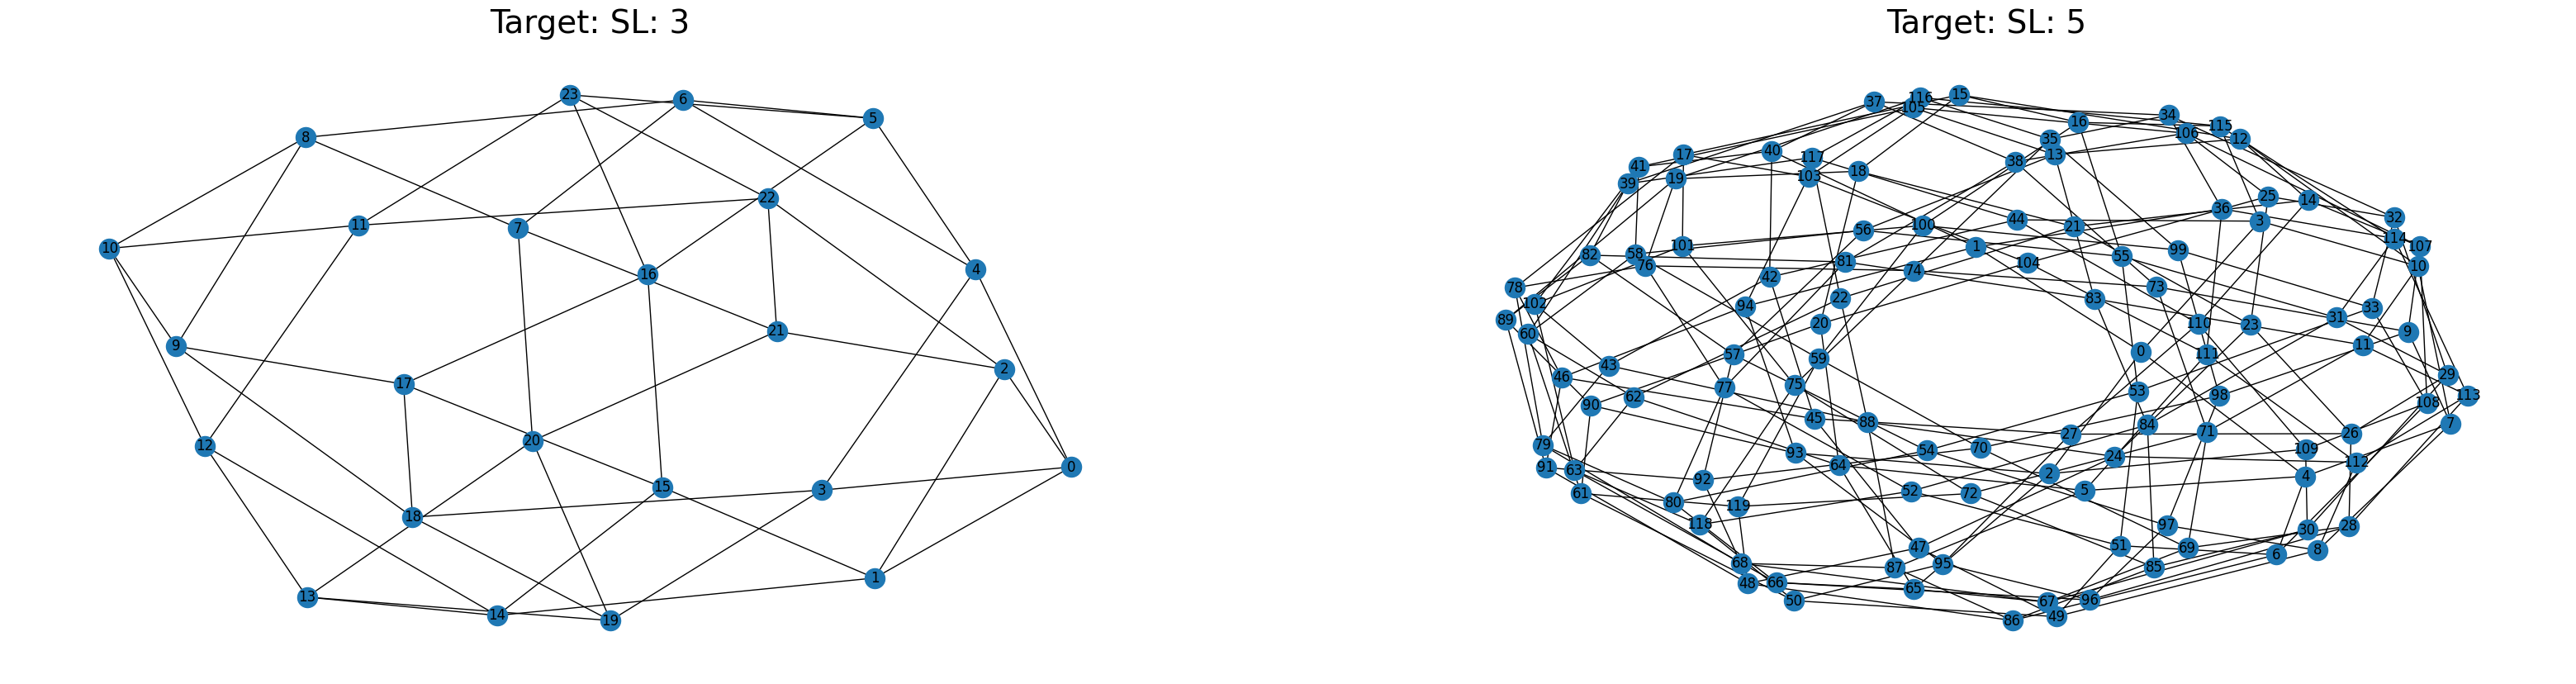

In [17]:
cayley_graph_sl_3 = Data(edge_index=get_cayley_graph(3))
cayley_graph_sl_5 = Data(edge_index=get_cayley_graph(5))

gallery([cayley_graph_sl_3, cayley_graph_sl_5], ['SL: 3', 'SL: 5'])

## Overview

For a fantastic  overview of  Graph Neural Networks (GNNS), I highly recommend the [EEML 2024: Geometric Deep Learning Tutorial](https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning) by Iulia Duta and Vladimir Mirjanić. It provides a stand-alone introduction into the realm of GNNs, including an informative starting point in to the current challenges; this provides a great introduction for the over-squashing problem also.

Once you have completed the above or have an idea of the *over-squashing* problem, the following sections will now build upon this by using some proposed methods (including CGP) on a real-world dataset.

### Over-squashing visualised

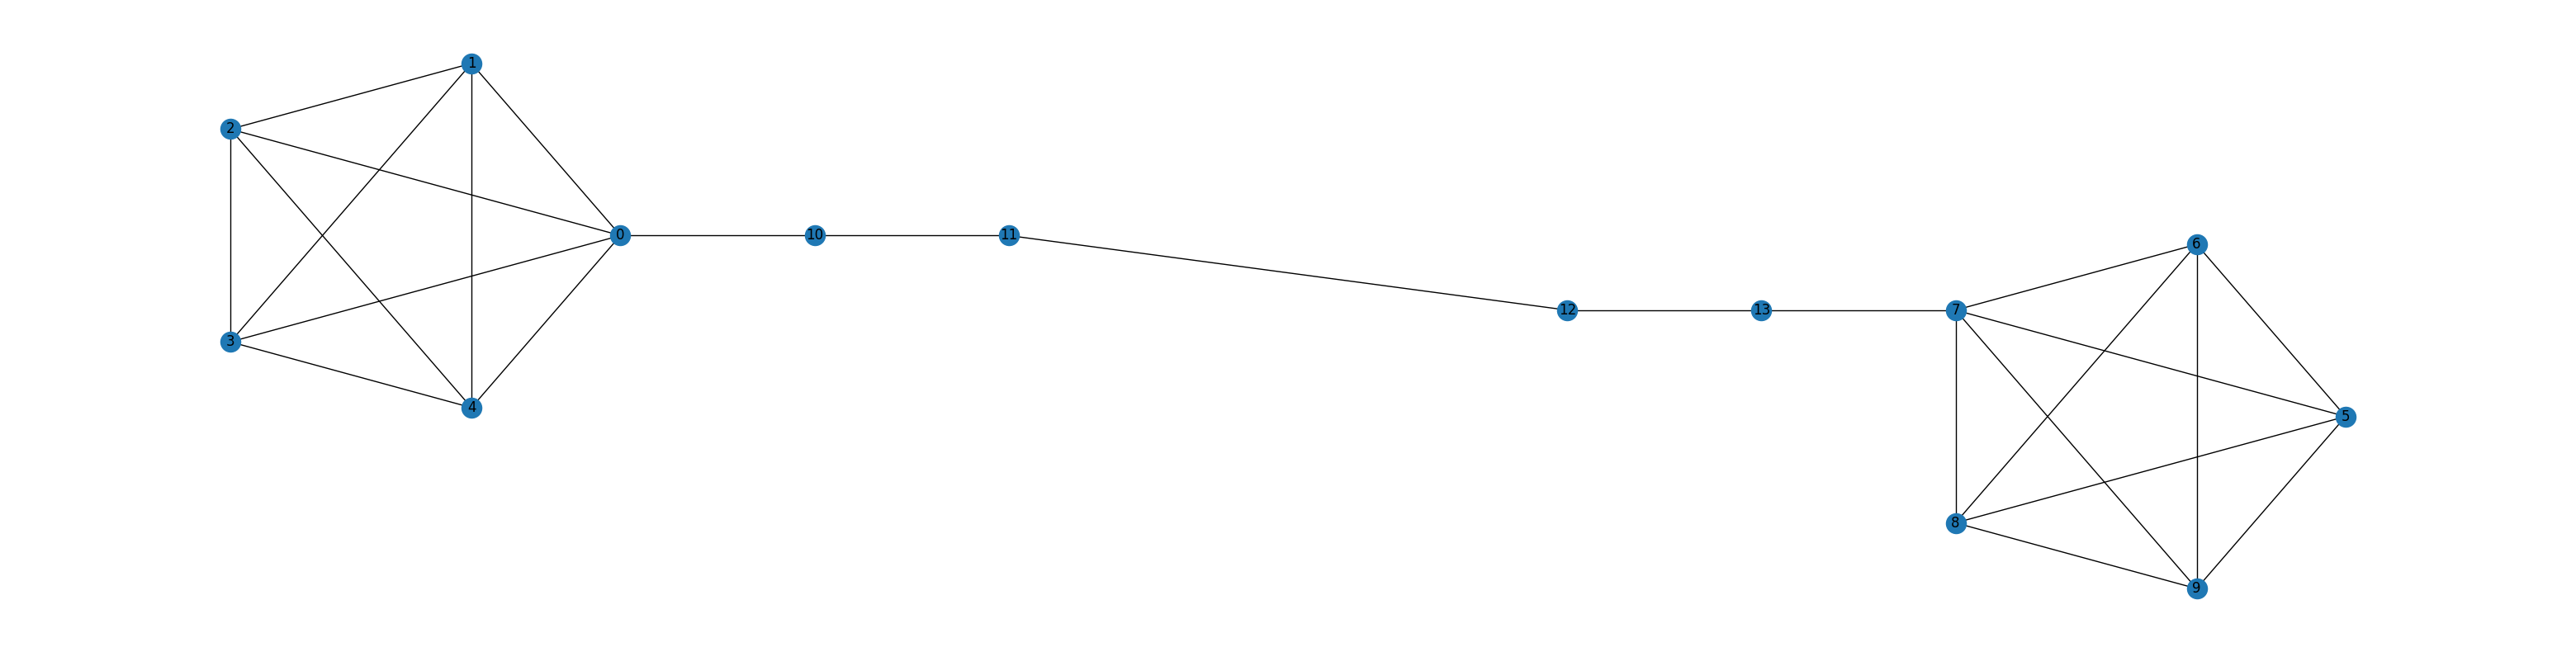

In [18]:
# Courtesy of: (EEML 2024 - https://github.com/eemlcommunity/PracticalSessions2024/tree/main/4_geometric_deep_learning)

barbell_graph = generate_barbell_graph(5, 4, target_label=[0, 0, 1])
gallery([barbell_graph], layout='custom')

The over-squashing problem was first identified by [Alon and Yahav](https://arxiv.org/abs/2006.05205) in which. For the above example, for the left-clique to communicate with the right-clique the messages need to travel through the connecting bridge (middle-region). However, this results in the *over-squashing* problem. Accordingly, this has stemmed from an abundance of fruitful research in which the topology of a graph is altered to better facilitate the message-passing paradigm. A simple solution as first presented by Alon and Yahov in the original [paper](https://arxiv.org/abs/2006.05205) is to make the graph *fully-connected*, meaning each pair of two nodes are connected. The popular Graph Transformer architecture is an example of this. However, a fully-connected graph poses the dilemma that with increasing graph sizes, the number of edges grows exponentially, thus a higher memory-usage! The practicality of this approach can therefore be limited by even the most modest graph sizes.

But first, let's generate some real-world data!

# Real-world examples

For a real-world example, we will leverage the popular [TUDataset](https://arxiv.org/abs/2007.08663). Here are the following possible datasets: ['MUTAG', 'ENZYMES', 'PROTEINS', 'COLLAB', 'IMDB-BINARY', 'REDDIT-BINARY'].

Our chosen dataset is `MUTAG`, as it only contains 188 graphs. It is a graph-classification task in which the aim is to predict their mutagenicity based on Salmonella typhimurium for the given input graph. Accordingly, it is a binary classification task that should have 2 classes for the entire input graph. This makes a very friendly example for any hardware and usable on Google Colab.

It is worth noting that due to the size of the dataset, only 18 graphs are used as part of the validation and test set. This is not ideal for thoroughly analysing the graph-rewiring techniques, therefore extending it to larger datasets is advisable. Like any good Deep Learning practitioner, a model should be run of the number of seeds to get a mean and standard deviation. Nevertheless, it makes for a great starting point.

## Real-world datasets

In [19]:
DATASET_NAME = 'MUTAG'

### Helper functions

In [20]:
from torch_geometric.datasets import TUDataset

# A helper function to load the TUDataset from PyG. If a transform is given it will also apply a pre_transformation to the dataset
# A pre_transformation means that that dataset does not need to be processed again, making it efficient for training purposes

def load_tu_dataset(dataset_name, transform_name='base'):
    pre_transform = None
    transform = None
    if transform_name == 'CGP':
        pre_transform = ExpanderTransform(dataset_name, transform_name)
    elif transform_name == 'EGP':
        pre_transform = ExpanderTransform(dataset_name, transform_name)
    elif transform_name == 'GTR':
        # Hyperparameters chosen per the GTR paper: https://arxiv.org/pdf/2302.06835
        pre_transform = PrecomputeGTREdges(num_edges=45)
        transform = AddPrecomputedGTREdges(num_edges=25)

    return TUDataset(name=dataset_name, root=f'datasets/{dataset_name.lower()}-{transform_name.lower()}', pre_transform=pre_transform, transform=transform)

In [21]:
from torch.utils.data import random_split

# This splits the dataset, using the same fraction as FoSR: https://arxiv.org/abs/2210.11790. The split is commonly used within the graph-rewiring community.

def get_split_datasets(complete_dataset):
    train_fraction = 0.8
    val_fraction = 0.1

    dataset_size = len(complete_dataset)
    train_size = int(train_fraction * dataset_size)
    validation_size = int(val_fraction * dataset_size)
    test_size = dataset_size - train_size - validation_size

    train_dataset, validation_dataset, test_dataset = random_split(complete_dataset,[train_size, validation_size, test_size])

    return train_dataset, validation_dataset, test_dataset

## Default example

For the default example, we shall load in the MUTAG dataset using the `load_tu_dataset` helper function. Afterwards, we can output the number of features and number of classes. In this case, MUTAG is a binary classification dataset to ensure it is what we expect.

In [22]:
base_complete_dataset = load_tu_dataset(DATASET_NAME)

Processing...
Done!


In [23]:
# We set the INPUT_DIM and OUTPUT_DIM for our GNN
INPUT_DIM = base_complete_dataset.num_features
OUTPUT_DIM = base_complete_dataset.num_classes

print(f'Number of node features: {INPUT_DIM}')
print(f'Number of classes: {OUTPUT_DIM}')

Number of node features: 7
Number of classes: 2


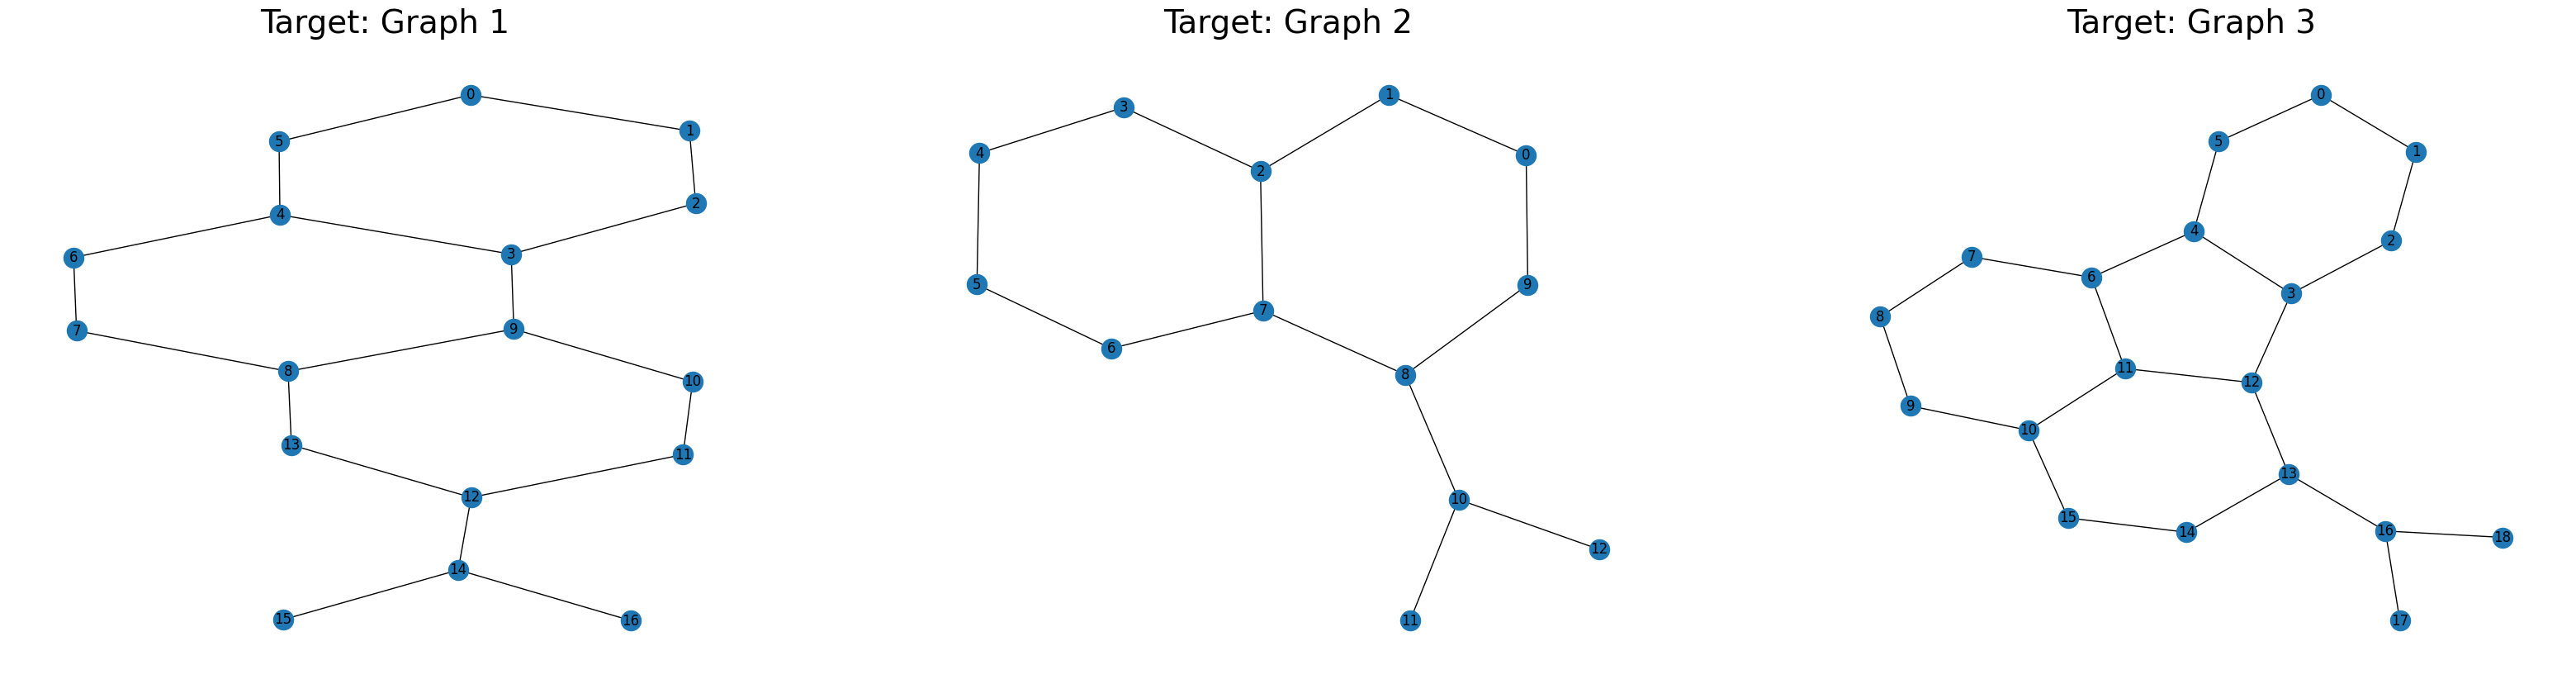

In [24]:
gallery([base_complete_dataset[0], base_complete_dataset[1], base_complete_dataset[3]], ['Graph 1', 'Graph 2', 'Graph 3'])

Now that we have an indication of the graph structure, lets train a model!

# Training a GNN

In [25]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# Hyperparameters: feel free to experiment with them as you see fit

# Training parameters
NUM_EPOCHS = 50
LR = 0.001
BATCH_SIZE = 64

# GNN
NUM_LAYERS = 4
HIDDEN_DIM = 64
DROPOUT = 0.5

## Model (including CGP)

The following section is a lightweight version of the model used in the Cayley Graph Propagation paper. The model is akin to the model provided by the [OGB Examples](https://github.com/snap-stanford/ogb). Of particular interest, is how we handle the *additional virtual nodes* as part of our CGP model. As stated in the paper, we simply use the additional virtual nodes as part of the propagation process and then truncate it to the original graph-size in downstream tasks. In this example we can see that it is done before the global pooling. Although this is the decision we have made, since the dataset has been modified to handle the additional virtual nodes you can technically perform inference on graph-structure which includes the virtual nodes.

Here is tl;dr of how CGP handles the virtual nodes.
- The node embeddings are expanded to include the virtual nodes, as per the ```batched_data.virtual_node_mask```. The ```batched_data.virtual_node_mask``` is a mask that provides an indicator to identify if it is a *virtual nodes*.
- Akin to EGP, we interweave the layers over default graph input, ```batched_data.edge_index```, and the Cayley graph ```batched_data.expander_edge_index```.
- The ```batched_data.virtual_node_mask``` can then be used to truncate the input graph structure back to the original size.

In [27]:
from torch_geometric.nn.conv import GINConv
from torch_geometric.nn import global_mean_pool

class GNN_node(torch.nn.Module):
    def __init__(self, transform_name, is_cgp):
        super(GNN_node, self).__init__()

        self.transform_name = transform_name
        self.is_cgp = transform_name in ['EGP', 'CGP'] and is_cgp
        self.num_layer = NUM_LAYERS
        self.drop_ratio = DROPOUT

        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()

        for layer in range(self.num_layer):
            input_dim = INPUT_DIM if layer == 0 else HIDDEN_DIM

            gnn_nn = nn.Sequential(
                nn.Linear(input_dim, HIDDEN_DIM),
                nn.BatchNorm1d(HIDDEN_DIM),
                nn.ReLU(),
                nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
            )
            self.convs.append(GINConv(gnn_nn))

            self.batch_norms.append(torch.nn.BatchNorm1d(HIDDEN_DIM))

    def forward(self, batched_data):
        x, edge_index = batched_data.x, batched_data.edge_index

        if self.is_cgp:
            # Expander the embeddings with the virtual nodes
            x_embeddings = torch.zeros((x.shape[0], x.shape[1]), device=x.device) # Here, we just set the embeddings to zero
            x_embeddings[~batched_data.virtual_node_mask] = x[~batched_data.virtual_node_mask]

            h_list = [x_embeddings]
        else:
            h_list = [x.float()] # Default embeddings

        for layer in range(self.num_layer):
            # Interweave the alternative layers over an expander layer
            if self.transform_name in ['EGP', 'CGP'] and layer % 2 == 1:
                h = self.convs[layer](h_list[layer], batched_data.expander_edge_index)
            else:
                h = self.convs[layer](h_list[layer], edge_index)
            h = self.batch_norms[layer](h)

            if layer == self.num_layer - 1:
                h = F.dropout(h, self.drop_ratio)
            else:
                h = F.dropout(F.relu(h), self.drop_ratio)

            h_list.append(h)

        node_representation = h_list[-1]

        return node_representation

In [28]:
# CGP Model
class GNN(torch.nn.Module):
    def __init__(self, transform_name=None, is_cgp=False):
        super(GNN, self).__init__()

        self.is_cgp = is_cgp
        self.gnn_node = GNN_node(transform_name, is_cgp)
        self.pool = global_mean_pool
        self.graph_pred_linear = torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM)

    def forward(self, batched_data):
        h_node = self.gnn_node(batched_data)

        # For CGP, truncate the h_node for downstream tasks, such as global pooling
        if self.is_cgp:
            h_node = h_node[~batched_data.virtual_node_mask]
            batch_indicator = batched_data.batch[~batched_data.virtual_node_mask]
        else:
            batch_indicator = batched_data.batch

        h_graph = self.pool(h_node, batch_indicator)

        return self.graph_pred_linear(h_graph)

## Training Utils

In [29]:
# A simple method to train our GNN
def train(model, loader, optimiser, loss_fn):
    model.train()

    for _, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(DEVICE)
        y = batch.y.to(DEVICE)

        out = model(batch)
        optimiser.zero_grad()

        loss = loss_fn(input=out, target=y)
        loss.backward()
        optimiser.step()

In [30]:
# An evaluation method to predict the accuracy
def eval(model, loader):
    model.eval()
    sample_size = len(loader.dataset)
    with torch.no_grad():
        total_correct = 0
        for batch in loader:
            batch = batch.to(DEVICE)
            y = batch.y.to(DEVICE)
            out = model(batch)
            _, pred = out.max(dim=1)
            total_correct += pred.eq(y).sum().item()

    return total_correct / sample_size

In [31]:
# Our main method to run the entire experiement based on the number of epochs
def run_experiment(model, train_loader, validation_loader, test_loader):
    optimiser = torch.optim.Adam(model.parameters(), lr=LR)
    loss_fn = torch.nn.CrossEntropyLoss()

    train_curve = []
    validation_curve = []
    test_curve = []

    print("Start training")
    for epoch in range(1, 1 + NUM_EPOCHS):
        print(f'Epoch: {epoch}')
        model.train()

        print("Start training...")
        train(model, train_loader, optimiser=optimiser, loss_fn=loss_fn)

        # Evaluate at every epoch
        train_acc = eval(model, train_loader)
        validation_acc = eval(model, validation_loader)
        test_acc = eval(model, test_loader)

        train_curve.append(train_acc)
        validation_curve.append(validation_acc)
        test_curve.append(test_acc)

        print(f'Train acc: {train_acc}, validation acc: {validation_acc}, test acc: {test_acc}\n')

    # Get the best validation score, which is used for cross-validation
    best_validation_epoch = np.argmax(np.array(validation_curve))

    print('Finished training!')
    print(f'Best validation score: {validation_curve[best_validation_epoch]}')
    print(f'Final test score: {test_curve[best_validation_epoch]}')

# Training the base graph example

In [32]:
base_model = GNN().to(DEVICE) # Intialise the base model and set it to our device

In [33]:
base_train_dataset, base_validation_dataset, base_test_dataset = get_split_datasets(base_complete_dataset)

base_train_loader = DataLoader(base_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
base_validation_loader = DataLoader(base_validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
base_test_loader = DataLoader(base_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
run_experiment(base_model, base_train_loader, base_validation_loader, base_test_loader)

Start training
Epoch: 1
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00,  8.11it/s]


Train acc: 0.68, validation acc: 0.6111111111111112, test acc: 0.6

Epoch: 2
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 256.26it/s]


Train acc: 0.68, validation acc: 0.6111111111111112, test acc: 0.6

Epoch: 3
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 165.15it/s]


Train acc: 0.6733333333333333, validation acc: 0.6111111111111112, test acc: 0.6

Epoch: 4
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 262.46it/s]


Train acc: 0.6866666666666666, validation acc: 0.6111111111111112, test acc: 0.6

Epoch: 5
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 283.39it/s]


Train acc: 0.6933333333333334, validation acc: 0.6666666666666666, test acc: 0.6

Epoch: 6
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 244.29it/s]


Train acc: 0.7266666666666667, validation acc: 0.6111111111111112, test acc: 0.7

Epoch: 7
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 272.83it/s]


Train acc: 0.72, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 8
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 266.79it/s]


Train acc: 0.7333333333333333, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 9
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 269.46it/s]


Train acc: 0.8, validation acc: 0.8888888888888888, test acc: 0.75

Epoch: 10
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 280.68it/s]


Train acc: 0.7533333333333333, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 11
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 277.90it/s]


Train acc: 0.7866666666666666, validation acc: 0.6666666666666666, test acc: 0.8

Epoch: 12
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 282.81it/s]


Train acc: 0.7666666666666667, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 13
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 291.16it/s]


Train acc: 0.8, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 14
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 319.76it/s]


Train acc: 0.8266666666666667, validation acc: 0.6111111111111112, test acc: 0.6

Epoch: 15
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 287.77it/s]


Train acc: 0.8533333333333334, validation acc: 0.5555555555555556, test acc: 0.6

Epoch: 16
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 307.59it/s]


Train acc: 0.8133333333333334, validation acc: 0.6666666666666666, test acc: 0.65

Epoch: 17
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 231.47it/s]


Train acc: 0.78, validation acc: 0.6666666666666666, test acc: 0.85

Epoch: 18
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 296.76it/s]


Train acc: 0.8266666666666667, validation acc: 0.6666666666666666, test acc: 0.75

Epoch: 19
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 276.39it/s]


Train acc: 0.8, validation acc: 0.7222222222222222, test acc: 0.9

Epoch: 20
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 304.37it/s]


Train acc: 0.7666666666666667, validation acc: 0.6666666666666666, test acc: 0.75

Epoch: 21
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 285.55it/s]


Train acc: 0.82, validation acc: 0.6111111111111112, test acc: 0.8

Epoch: 22
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 282.72it/s]


Train acc: 0.8466666666666667, validation acc: 0.6111111111111112, test acc: 0.8

Epoch: 23
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 320.21it/s]


Train acc: 0.7866666666666666, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 24
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 322.30it/s]


Train acc: 0.82, validation acc: 0.7777777777777778, test acc: 0.85

Epoch: 25
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 309.35it/s]


Train acc: 0.8066666666666666, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 26
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 313.01it/s]


Train acc: 0.84, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 27
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 302.95it/s]


Train acc: 0.8333333333333334, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 28
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 320.63it/s]


Train acc: 0.8466666666666667, validation acc: 0.6111111111111112, test acc: 0.8

Epoch: 29
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 317.14it/s]


Train acc: 0.8133333333333334, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 30
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 286.32it/s]


Train acc: 0.8266666666666667, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 31
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.79it/s]


Train acc: 0.84, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 32
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 288.55it/s]


Train acc: 0.8133333333333334, validation acc: 0.6111111111111112, test acc: 0.8

Epoch: 33
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 294.02it/s]


Train acc: 0.82, validation acc: 0.6111111111111112, test acc: 0.85

Epoch: 34
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 312.52it/s]


Train acc: 0.82, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 35
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 320.86it/s]


Train acc: 0.8, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 36
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 316.61it/s]


Train acc: 0.8733333333333333, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 37
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 285.37it/s]


Train acc: 0.8466666666666667, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 38
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 311.81it/s]


Train acc: 0.8466666666666667, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 39
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 306.47it/s]


Train acc: 0.8466666666666667, validation acc: 0.5555555555555556, test acc: 0.75

Epoch: 40
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 310.26it/s]


Train acc: 0.7733333333333333, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 41
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 295.17it/s]


Train acc: 0.8266666666666667, validation acc: 0.6111111111111112, test acc: 0.7

Epoch: 42
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 288.57it/s]


Train acc: 0.8466666666666667, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 43
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 291.18it/s]


Train acc: 0.8866666666666667, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 44
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 283.28it/s]


Train acc: 0.8333333333333334, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 45
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 226.44it/s]


Train acc: 0.8133333333333334, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 46
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 268.36it/s]


Train acc: 0.82, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 47
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.98it/s]


Train acc: 0.8866666666666667, validation acc: 0.7222222222222222, test acc: 0.9

Epoch: 48
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 253.33it/s]


Train acc: 0.8533333333333334, validation acc: 0.8333333333333334, test acc: 0.85

Epoch: 49
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 259.39it/s]


Train acc: 0.8666666666666667, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 50
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 284.22it/s]


Train acc: 0.8533333333333334, validation acc: 0.7222222222222222, test acc: 0.85

Finished training!
Best validation score: 0.8888888888888888
Final test score: 0.75


# Training EGP

In [35]:
# Here, we will load the same dataset but apply the EGP transformation. If done correctly there should be an 'expander_edge_index'
egp_complete_dataset = load_tu_dataset(DATASET_NAME, transform_name='EGP')

Processing...
Done!


In [36]:
egp_complete_dataset[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1], expander_edge_index=[2, 52])

In [37]:
egp_graph_1 = Data(edge_index=egp_complete_dataset[0].expander_edge_index)
egp_graph_2 = Data(edge_index=egp_complete_dataset[1].expander_edge_index)

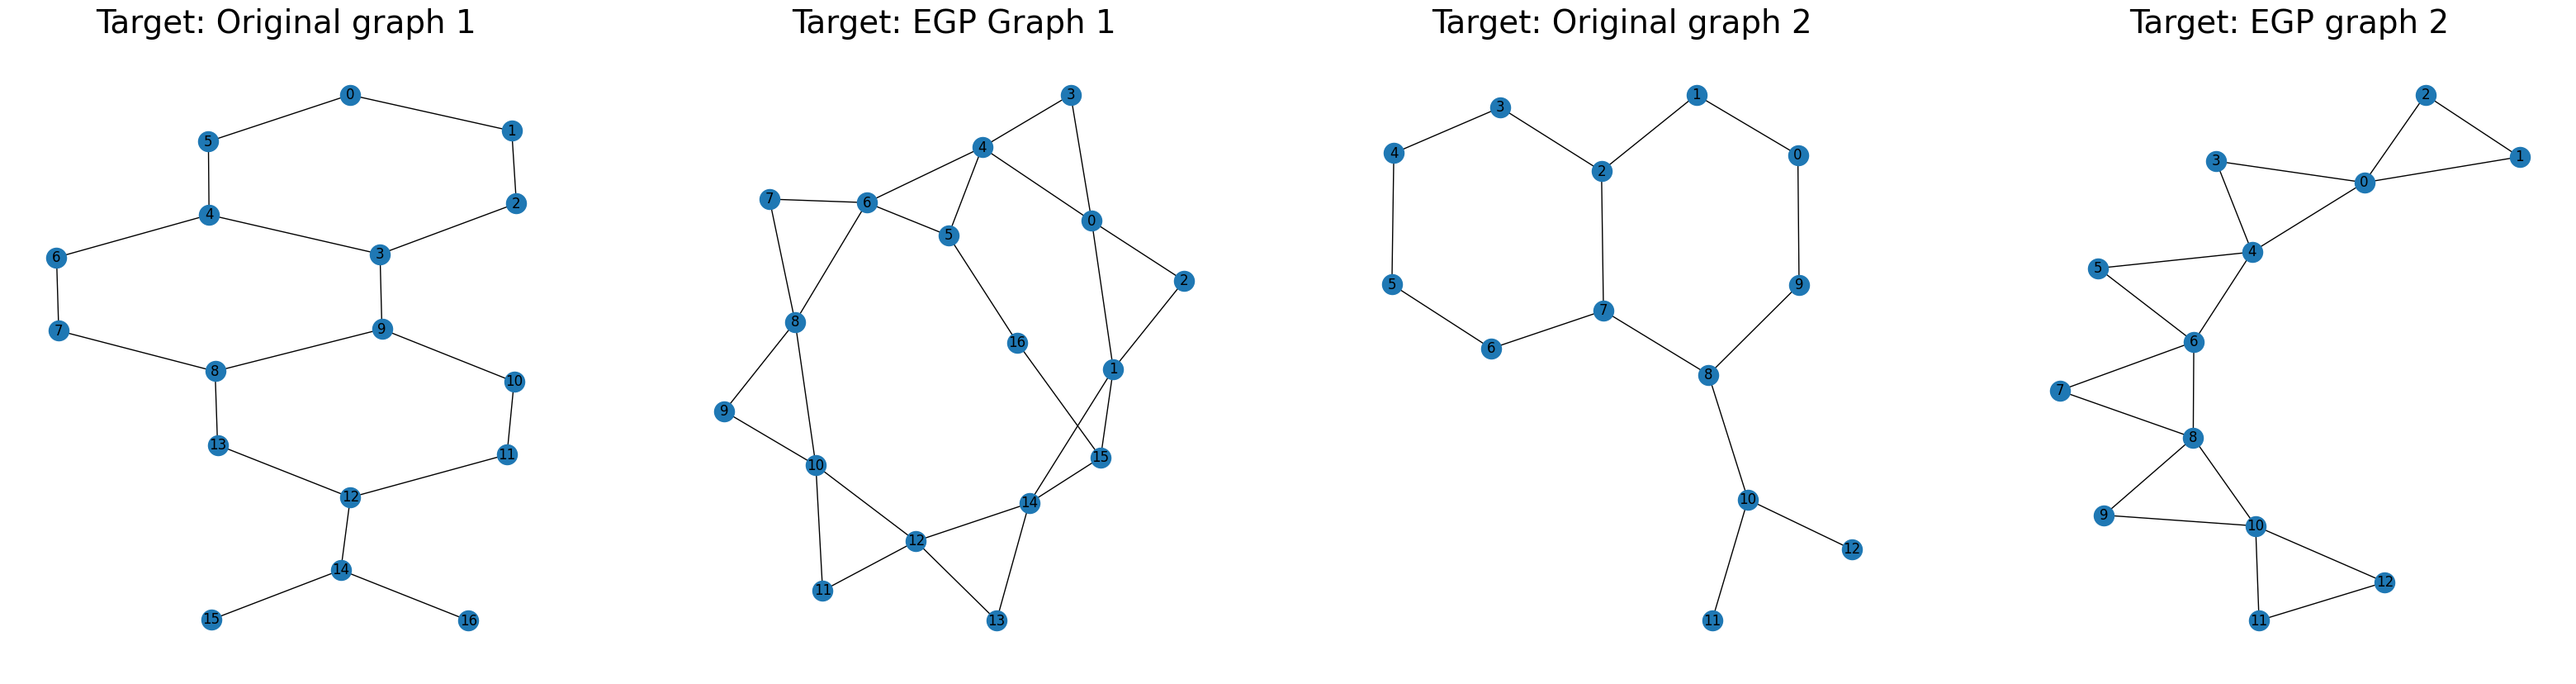

In [38]:
gallery([egp_complete_dataset[0], egp_graph_1, egp_complete_dataset[1], egp_graph_2], ['Original graph 1', 'EGP Graph 1', 'Original graph 2', 'EGP graph 2'])

Here, are the generated Expander graphs as used by EGP in relation to the input graph. However in comparison to the graphs shown in our Cayley graph visualisation, the *truncation* can have an adverse impact on the deserible properties. For example, there is still a particular high commute time between node 1 and 12 for 'EGP graph 2'.

In [39]:
egp_train_dataset, egp_validation_dataset, egp_test_dataset = get_split_datasets(egp_complete_dataset)

egp_train_loader = DataLoader(egp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
egp_validation_loader = DataLoader(egp_validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
egp_test_loader = DataLoader(egp_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
egp_model = GNN(transform_name='EGP').to(DEVICE)

In [41]:
run_experiment(egp_model, egp_train_loader, egp_validation_loader, egp_test_loader)

Start training
Epoch: 1
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 154.69it/s]


Train acc: 0.7066666666666667, validation acc: 0.6666666666666666, test acc: 0.5

Epoch: 2
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 236.39it/s]


Train acc: 0.7, validation acc: 0.6111111111111112, test acc: 0.45

Epoch: 3
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 236.86it/s]


Train acc: 0.7, validation acc: 0.6111111111111112, test acc: 0.45

Epoch: 4
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 239.06it/s]


Train acc: 0.7, validation acc: 0.6111111111111112, test acc: 0.45

Epoch: 5
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 231.88it/s]


Train acc: 0.7133333333333334, validation acc: 0.6111111111111112, test acc: 0.55

Epoch: 6
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 234.58it/s]


Train acc: 0.78, validation acc: 0.7777777777777778, test acc: 0.5

Epoch: 7
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 238.28it/s]


Train acc: 0.7933333333333333, validation acc: 0.7777777777777778, test acc: 0.6

Epoch: 8
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 232.59it/s]


Train acc: 0.8133333333333334, validation acc: 0.7222222222222222, test acc: 0.65

Epoch: 9
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 221.01it/s]


Train acc: 0.7866666666666666, validation acc: 0.7222222222222222, test acc: 0.55

Epoch: 10
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 236.65it/s]


Train acc: 0.8066666666666666, validation acc: 0.8333333333333334, test acc: 0.65

Epoch: 11
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 235.90it/s]


Train acc: 0.8333333333333334, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 12
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 232.15it/s]


Train acc: 0.7866666666666666, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 13
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 223.27it/s]


Train acc: 0.8266666666666667, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 14
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 234.48it/s]


Train acc: 0.7933333333333333, validation acc: 0.8333333333333334, test acc: 0.65

Epoch: 15
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 229.58it/s]


Train acc: 0.84, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 16
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 233.44it/s]


Train acc: 0.86, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 17
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 222.45it/s]


Train acc: 0.8466666666666667, validation acc: 0.9444444444444444, test acc: 0.75

Epoch: 18
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.51it/s]


Train acc: 0.7933333333333333, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 19
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 218.91it/s]


Train acc: 0.8666666666666667, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 20
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 226.25it/s]


Train acc: 0.8333333333333334, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 21
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.52it/s]


Train acc: 0.82, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 22
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 228.88it/s]


Train acc: 0.8133333333333334, validation acc: 0.8333333333333334, test acc: 0.65

Epoch: 23
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 240.99it/s]


Train acc: 0.7733333333333333, validation acc: 0.7777777777777778, test acc: 0.6

Epoch: 24
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 237.98it/s]


Train acc: 0.8, validation acc: 0.8888888888888888, test acc: 0.75

Epoch: 25
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 231.71it/s]


Train acc: 0.8266666666666667, validation acc: 0.7222222222222222, test acc: 0.6

Epoch: 26
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 212.77it/s]


Train acc: 0.8866666666666667, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 27
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 248.90it/s]


Train acc: 0.8, validation acc: 0.7222222222222222, test acc: 0.6

Epoch: 28
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 254.22it/s]


Train acc: 0.82, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 29
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 255.35it/s]


Train acc: 0.8733333333333333, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 30
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 254.17it/s]


Train acc: 0.9, validation acc: 0.7777777777777778, test acc: 0.85

Epoch: 31
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 243.16it/s]


Train acc: 0.8466666666666667, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 32
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 232.02it/s]


Train acc: 0.8333333333333334, validation acc: 0.8333333333333334, test acc: 0.7

Epoch: 33
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 258.93it/s]


Train acc: 0.82, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 34
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 260.49it/s]


Train acc: 0.8466666666666667, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 35
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 259.37it/s]


Train acc: 0.84, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 36
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 248.73it/s]


Train acc: 0.86, validation acc: 0.8888888888888888, test acc: 0.55

Epoch: 37
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 229.40it/s]


Train acc: 0.8333333333333334, validation acc: 0.8333333333333334, test acc: 0.55

Epoch: 38
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 248.39it/s]


Train acc: 0.8266666666666667, validation acc: 0.9444444444444444, test acc: 0.55

Epoch: 39
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 257.61it/s]


Train acc: 0.86, validation acc: 0.8333333333333334, test acc: 0.7

Epoch: 40
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 244.45it/s]


Train acc: 0.8333333333333334, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 41
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 236.42it/s]


Train acc: 0.8933333333333333, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 42
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 251.62it/s]


Train acc: 0.8866666666666667, validation acc: 0.8333333333333334, test acc: 0.7

Epoch: 43
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 255.11it/s]


Train acc: 0.88, validation acc: 0.7777777777777778, test acc: 0.85

Epoch: 44
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 259.21it/s]


Train acc: 0.9133333333333333, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 45
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 252.32it/s]


Train acc: 0.88, validation acc: 0.8333333333333334, test acc: 0.65

Epoch: 46
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 233.34it/s]


Train acc: 0.8733333333333333, validation acc: 0.8888888888888888, test acc: 0.7

Epoch: 47
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 247.72it/s]


Train acc: 0.88, validation acc: 0.9444444444444444, test acc: 0.7

Epoch: 48
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 253.45it/s]


Train acc: 0.8666666666666667, validation acc: 0.6666666666666666, test acc: 0.75

Epoch: 49
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 256.93it/s]


Train acc: 0.8933333333333333, validation acc: 0.8333333333333334, test acc: 0.7

Epoch: 50
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 264.91it/s]


Train acc: 0.8866666666666667, validation acc: 0.8333333333333334, test acc: 0.8

Finished training!
Best validation score: 0.9444444444444444
Final test score: 0.75


# Training CGP

In [42]:
cgp_complete_dataset = load_tu_dataset(DATASET_NAME, transform_name='CGP')

Processing...
Done!


In [43]:
cgp_graph_1 = Data(edge_index=cgp_complete_dataset[0].expander_edge_index)
cgp_graph_2 = Data(edge_index=cgp_complete_dataset[1].expander_edge_index)

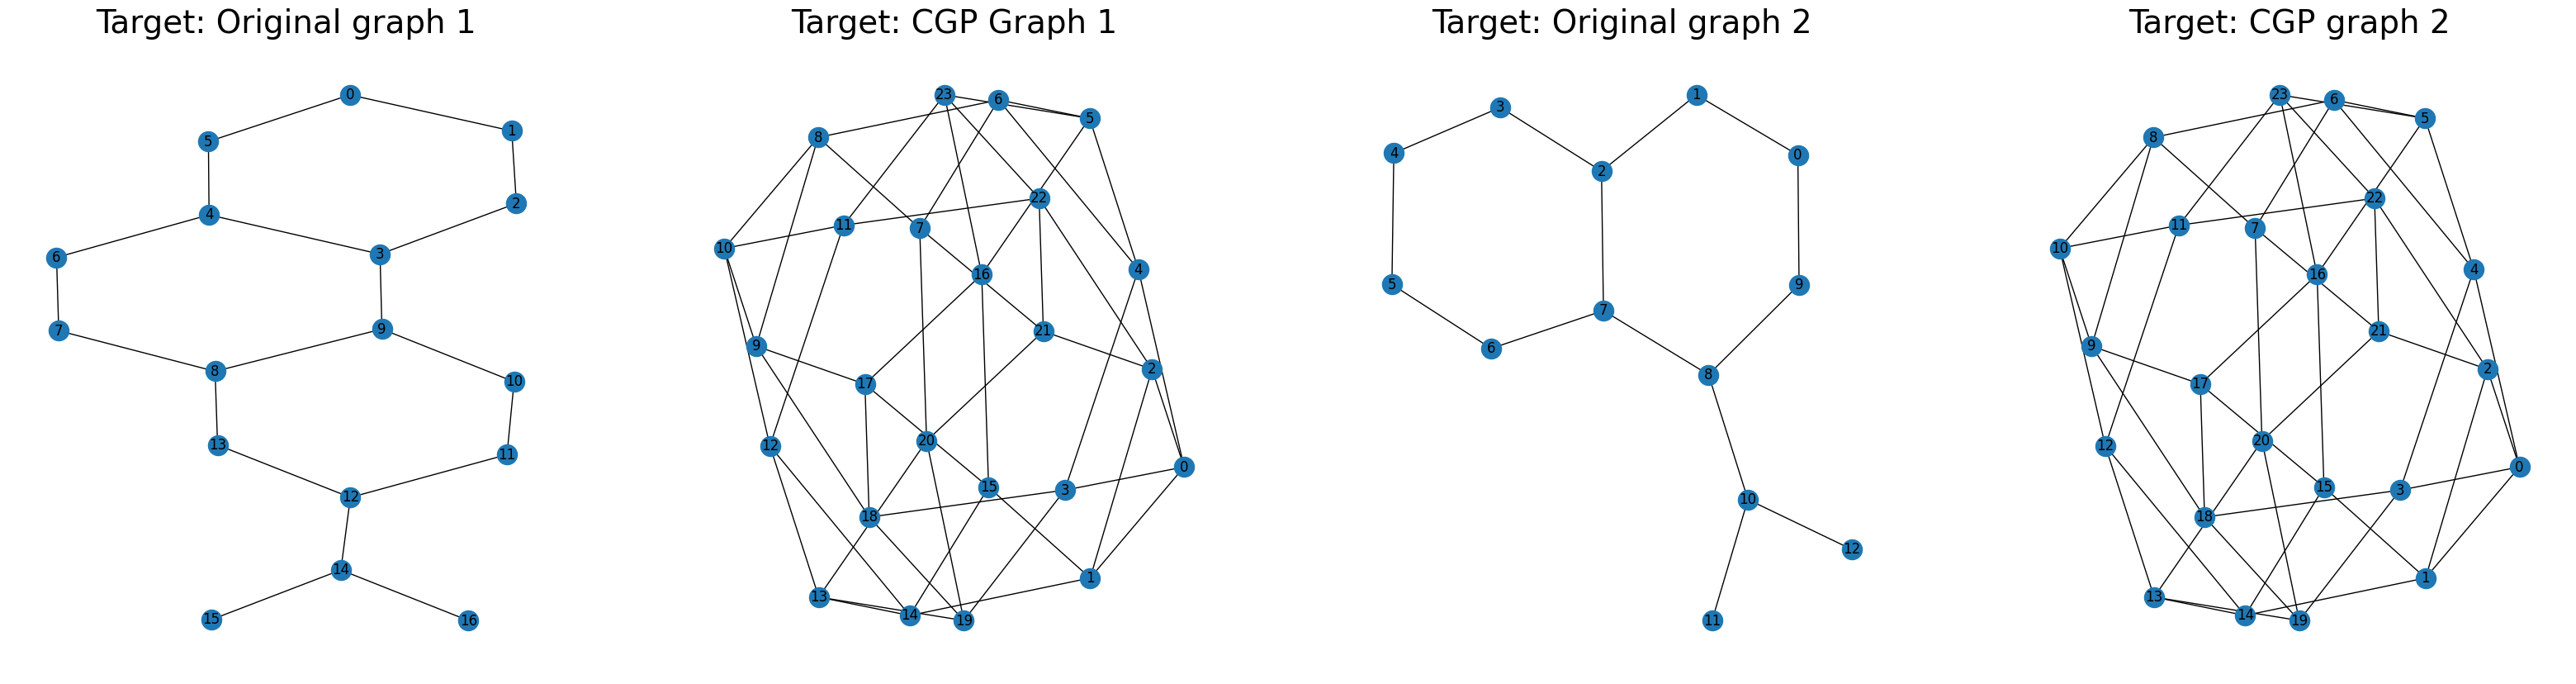

In [44]:
gallery([cgp_complete_dataset[0], cgp_graph_1, cgp_complete_dataset[1], cgp_graph_2], ['Original graph 1', 'CGP Graph 1', 'Original graph 2', 'CGP graph 2'])

Since CGP does not truncate the graphs, we can see the Target CGP Graph(s) all have deserible looking properties. Lets see how they perform on the MUTAG dataset...

In [45]:
cgp_train_dataset, cgp_validation_dataset, cgp_test_dataset = get_split_datasets(cgp_complete_dataset)

In [46]:
cgp_train_loader = DataLoader(cgp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
cgp_validation_loader = DataLoader(cgp_validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
cgp_test_loader = DataLoader(cgp_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [47]:
cayley_model = GNN(transform_name='CGP', is_cgp=True).to(DEVICE)

In [48]:
run_experiment(cayley_model, cgp_train_loader, cgp_validation_loader, cgp_test_loader)

Start training
Epoch: 1
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 30.50it/s]


Train acc: 0.6266666666666667, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 2
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 230.65it/s]


Train acc: 0.6466666666666666, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 3
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 225.95it/s]


Train acc: 0.68, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 4
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 234.16it/s]


Train acc: 0.7, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 5
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 234.29it/s]


Train acc: 0.7333333333333333, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 6
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 235.23it/s]


Train acc: 0.7666666666666667, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 7
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 243.33it/s]


Train acc: 0.7533333333333333, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 8
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 217.47it/s]


Train acc: 0.7733333333333333, validation acc: 0.8333333333333334, test acc: 0.7

Epoch: 9
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 227.41it/s]


Train acc: 0.7666666666666667, validation acc: 0.9444444444444444, test acc: 0.95

Epoch: 10
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 214.76it/s]


Train acc: 0.8133333333333334, validation acc: 1.0, test acc: 0.9

Epoch: 11
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 227.84it/s]


Train acc: 0.8266666666666667, validation acc: 0.9444444444444444, test acc: 0.85

Epoch: 12
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 226.32it/s]


Train acc: 0.7933333333333333, validation acc: 0.8333333333333334, test acc: 0.85

Epoch: 13
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 218.97it/s]


Train acc: 0.82, validation acc: 0.8333333333333334, test acc: 0.95

Epoch: 14
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 225.48it/s]


Train acc: 0.82, validation acc: 0.8333333333333334, test acc: 0.95

Epoch: 15
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 217.30it/s]


Train acc: 0.8066666666666666, validation acc: 0.8888888888888888, test acc: 0.95

Epoch: 16
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 228.33it/s]


Train acc: 0.7733333333333333, validation acc: 1.0, test acc: 0.95

Epoch: 17
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 235.82it/s]


Train acc: 0.8333333333333334, validation acc: 0.8333333333333334, test acc: 0.95

Epoch: 18
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 239.08it/s]


Train acc: 0.8066666666666666, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 19
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 219.87it/s]


Train acc: 0.8133333333333334, validation acc: 0.8888888888888888, test acc: 0.95

Epoch: 20
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


Train acc: 0.8133333333333334, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 21
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 231.40it/s]


Train acc: 0.84, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 22
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 228.49it/s]


Train acc: 0.8133333333333334, validation acc: 0.8888888888888888, test acc: 0.85

Epoch: 23
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 217.83it/s]


Train acc: 0.8333333333333334, validation acc: 0.9444444444444444, test acc: 0.8

Epoch: 24
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 231.58it/s]


Train acc: 0.8333333333333334, validation acc: 0.9444444444444444, test acc: 0.85

Epoch: 25
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 230.42it/s]


Train acc: 0.86, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 26
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 248.13it/s]


Train acc: 0.8533333333333334, validation acc: 0.8333333333333334, test acc: 0.85

Epoch: 27
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 245.03it/s]


Train acc: 0.82, validation acc: 0.7777777777777778, test acc: 0.9

Epoch: 28
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 239.36it/s]


Train acc: 0.8133333333333334, validation acc: 0.8888888888888888, test acc: 0.9

Epoch: 29
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.46it/s]


Train acc: 0.84, validation acc: 0.8888888888888888, test acc: 0.9

Epoch: 30
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 239.39it/s]


Train acc: 0.86, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 31
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.78it/s]


Train acc: 0.8733333333333333, validation acc: 0.9444444444444444, test acc: 0.9

Epoch: 32
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 240.24it/s]


Train acc: 0.8533333333333334, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 33
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 247.07it/s]


Train acc: 0.8533333333333334, validation acc: 0.8888888888888888, test acc: 0.95

Epoch: 34
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 242.65it/s]


Train acc: 0.8533333333333334, validation acc: 0.9444444444444444, test acc: 0.85

Epoch: 35
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 221.06it/s]


Train acc: 0.86, validation acc: 0.9444444444444444, test acc: 0.95

Epoch: 36
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 236.61it/s]


Train acc: 0.84, validation acc: 0.9444444444444444, test acc: 0.8

Epoch: 37
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 245.81it/s]


Train acc: 0.8933333333333333, validation acc: 1.0, test acc: 0.95

Epoch: 38
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 248.59it/s]


Train acc: 0.86, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 39
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 249.67it/s]


Train acc: 0.8666666666666667, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 40
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 243.57it/s]


Train acc: 0.8733333333333333, validation acc: 0.8333333333333334, test acc: 0.85

Epoch: 41
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 245.55it/s]


Train acc: 0.8466666666666667, validation acc: 0.8333333333333334, test acc: 0.9

Epoch: 42
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 254.97it/s]


Train acc: 0.8333333333333334, validation acc: 0.8888888888888888, test acc: 0.95

Epoch: 43
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 246.97it/s]


Train acc: 0.8666666666666667, validation acc: 0.8888888888888888, test acc: 0.85

Epoch: 44
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.26it/s]


Train acc: 0.82, validation acc: 0.8333333333333334, test acc: 0.95

Epoch: 45
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 241.63it/s]


Train acc: 0.8666666666666667, validation acc: 0.9444444444444444, test acc: 0.95

Epoch: 46
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 249.59it/s]


Train acc: 0.8533333333333334, validation acc: 0.9444444444444444, test acc: 0.9

Epoch: 47
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 239.44it/s]


Train acc: 0.8533333333333334, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 48
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 251.77it/s]


Train acc: 0.8533333333333334, validation acc: 0.8888888888888888, test acc: 0.85

Epoch: 49
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 219.50it/s]


Train acc: 0.8866666666666667, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 50
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 226.15it/s]


Train acc: 0.8533333333333334, validation acc: 1.0, test acc: 0.9

Finished training!
Best validation score: 1.0
Final test score: 0.9


# [BONUS] Graph-rewiring example (GTR)

Even though it is out-of-scope of understanding our Cayley Graph Propagation, I decided that it would be useful to provide a graph-rewiring example to provide a comparison. Here, we can compare the outputted graph structure after a graph-rewiring technique is applied based on their optimisation target. In this case, we have decided to use [GTR](https://arxiv.org/pdf/2302.06835). For most graph-rewiring approaches, there is an associated hyperparameter used to modify the input graph structure based on the aforementioned optimisation target.

The datasets impose a pre-processing time, therefore loading the dataset may take longer.

In [49]:
gtr_complete_dataset = load_tu_dataset(DATASET_NAME, transform_name='GTR')

Processing...
Done!


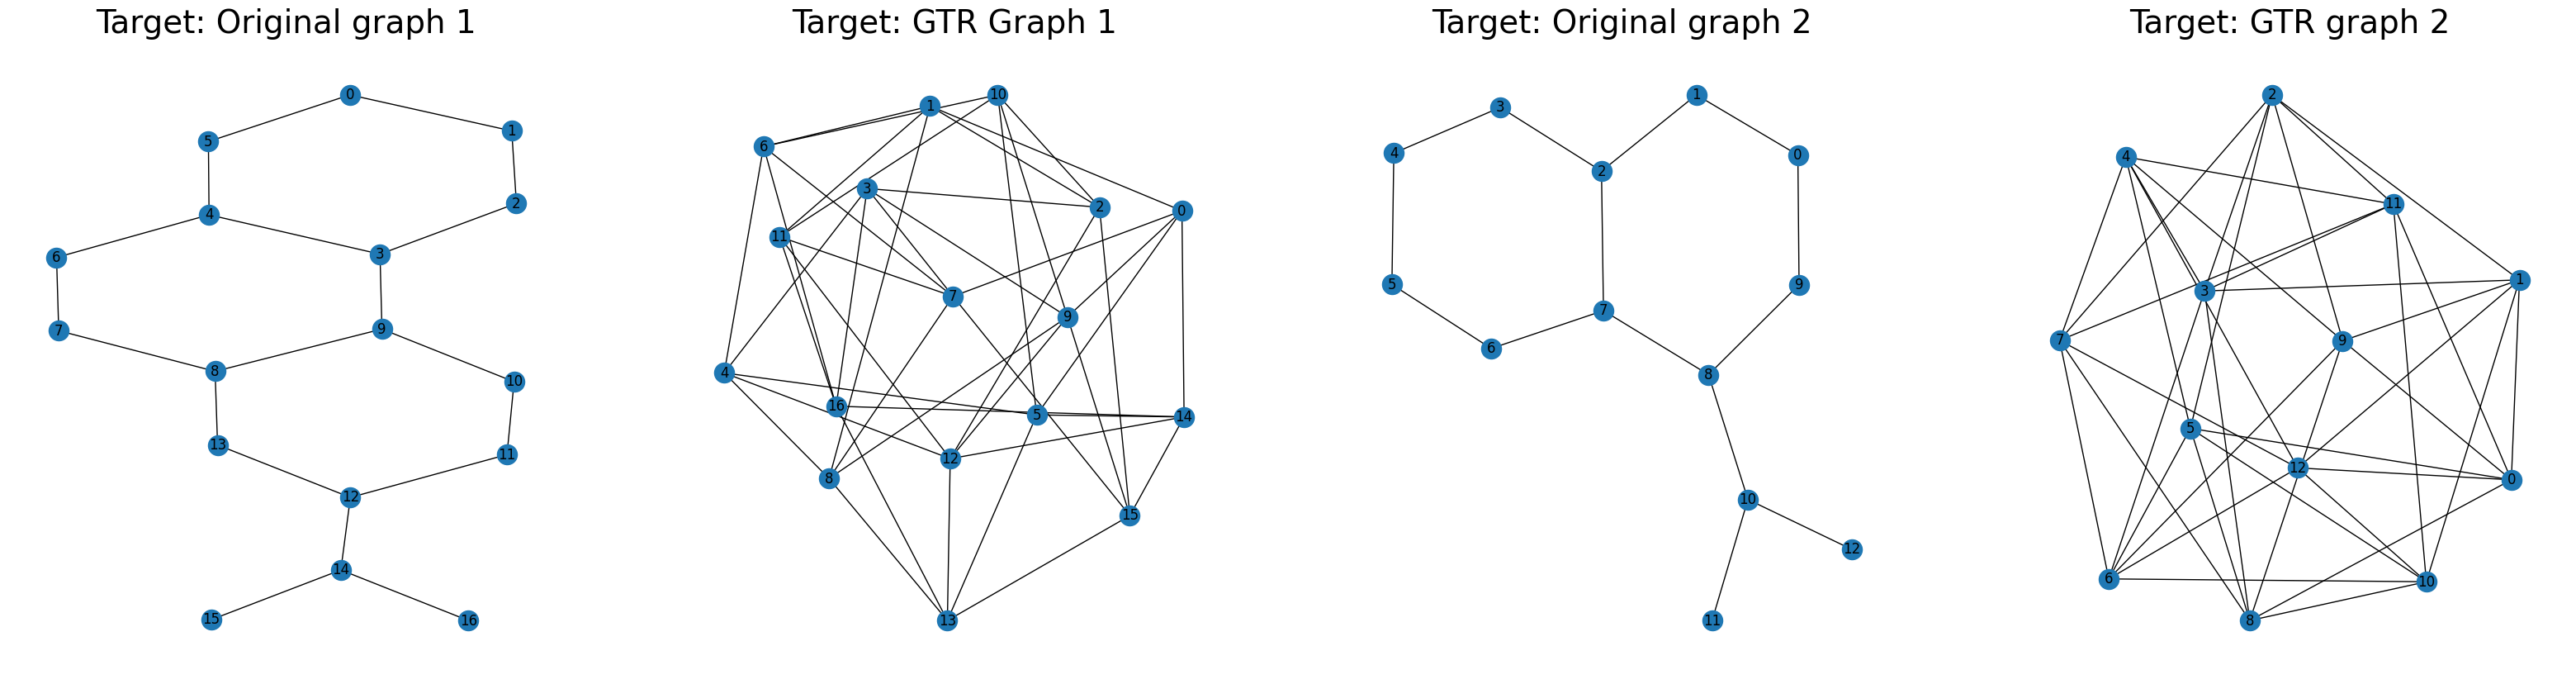

In [50]:
gallery([base_complete_dataset[0], gtr_complete_dataset[0], base_complete_dataset[1], gtr_complete_dataset[1]], ['Original graph 1', 'GTR Graph 1', 'Original graph 2', 'GTR graph 2'])

In [51]:
gtr_train_dataset, gtr_validation_dataset, gtr_test_dataset = get_split_datasets(gtr_complete_dataset)

In [52]:
gtr_train_loader = DataLoader(gtr_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
gtr_validation_loader = DataLoader(gtr_validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
gtr_test_loader = DataLoader(gtr_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
gtr_model = GNN(transform_name='GTR').to(DEVICE)

In [54]:
run_experiment(gtr_model, gtr_train_loader, gtr_validation_loader, gtr_test_loader)

Start training
Epoch: 1
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 132.24it/s]


Train acc: 0.31333333333333335, validation acc: 0.3888888888888889, test acc: 0.45

Epoch: 2
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 207.81it/s]


Train acc: 0.78, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 3
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 210.80it/s]


Train acc: 0.7333333333333333, validation acc: 0.7777777777777778, test acc: 0.6

Epoch: 4
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 207.23it/s]


Train acc: 0.7066666666666667, validation acc: 0.6666666666666666, test acc: 0.55

Epoch: 5
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 219.02it/s]


Train acc: 0.7066666666666667, validation acc: 0.6666666666666666, test acc: 0.65

Epoch: 6
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 212.34it/s]


Train acc: 0.7666666666666667, validation acc: 0.6666666666666666, test acc: 0.65

Epoch: 7
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 206.92it/s]


Train acc: 0.7866666666666666, validation acc: 0.7222222222222222, test acc: 0.6

Epoch: 8
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 213.53it/s]


Train acc: 0.8066666666666666, validation acc: 0.6666666666666666, test acc: 0.7

Epoch: 9
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 209.19it/s]


Train acc: 0.82, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 10
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.84it/s]


Train acc: 0.8733333333333333, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 11
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 214.75it/s]


Train acc: 0.86, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 12
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 210.80it/s]


Train acc: 0.84, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 13
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 215.83it/s]


Train acc: 0.8133333333333334, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 14
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 205.19it/s]


Train acc: 0.88, validation acc: 0.7777777777777778, test acc: 0.65

Epoch: 15
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 204.40it/s]


Train acc: 0.8733333333333333, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 16
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 204.38it/s]


Train acc: 0.88, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 17
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 213.33it/s]


Train acc: 0.8733333333333333, validation acc: 0.6666666666666666, test acc: 0.8

Epoch: 18
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 204.84it/s]


Train acc: 0.8933333333333333, validation acc: 0.7777777777777778, test acc: 0.6

Epoch: 19
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 213.45it/s]


Train acc: 0.8533333333333334, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 20
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 212.28it/s]


Train acc: 0.88, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 21
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 215.93it/s]


Train acc: 0.9, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 22
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 212.37it/s]


Train acc: 0.8733333333333333, validation acc: 0.8888888888888888, test acc: 0.8

Epoch: 23
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 217.94it/s]


Train acc: 0.8866666666666667, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 24
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 217.75it/s]


Train acc: 0.8733333333333333, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 25
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 222.11it/s]


Train acc: 0.8466666666666667, validation acc: 0.6666666666666666, test acc: 0.75

Epoch: 26
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 204.88it/s]


Train acc: 0.88, validation acc: 0.7222222222222222, test acc: 0.75

Epoch: 27
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 214.97it/s]


Train acc: 0.84, validation acc: 0.7777777777777778, test acc: 0.65

Epoch: 28
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 214.15it/s]


Train acc: 0.8666666666666667, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 29
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 205.74it/s]


Train acc: 0.88, validation acc: 0.7222222222222222, test acc: 0.7

Epoch: 30
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 218.89it/s]


Train acc: 0.8866666666666667, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 31
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 216.45it/s]


Train acc: 0.88, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 32
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.62it/s]


Train acc: 0.8933333333333333, validation acc: 0.6666666666666666, test acc: 0.65

Epoch: 33
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.42it/s]


Train acc: 0.9, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 34
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 208.28it/s]


Train acc: 0.9066666666666666, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 35
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 208.99it/s]


Train acc: 0.8733333333333333, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 36
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.81it/s]


Train acc: 0.9, validation acc: 0.7777777777777778, test acc: 0.75

Epoch: 37
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 199.53it/s]


Train acc: 0.8933333333333333, validation acc: 0.8888888888888888, test acc: 0.75

Epoch: 38
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 218.46it/s]


Train acc: 0.9, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 39
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 211.07it/s]


Train acc: 0.8933333333333333, validation acc: 0.7777777777777778, test acc: 0.85

Epoch: 40
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 207.56it/s]


Train acc: 0.8933333333333333, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 41
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 210.75it/s]


Train acc: 0.8933333333333333, validation acc: 0.7777777777777778, test acc: 0.7

Epoch: 42
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 223.57it/s]


Train acc: 0.9, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 43
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 214.22it/s]


Train acc: 0.9066666666666666, validation acc: 0.7777777777777778, test acc: 0.8

Epoch: 44
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 191.49it/s]


Train acc: 0.9133333333333333, validation acc: 0.8333333333333334, test acc: 0.6

Epoch: 45
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 220.75it/s]


Train acc: 0.88, validation acc: 0.8333333333333334, test acc: 0.75

Epoch: 46
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 222.15it/s]


Train acc: 0.9, validation acc: 0.7222222222222222, test acc: 0.8

Epoch: 47
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 227.01it/s]


Train acc: 0.86, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 48
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 215.31it/s]


Train acc: 0.8866666666666667, validation acc: 0.7222222222222222, test acc: 0.85

Epoch: 49
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 222.04it/s]


Train acc: 0.9133333333333333, validation acc: 0.8333333333333334, test acc: 0.8

Epoch: 50
Start training...


Iteration: 100%|██████████| 3/3 [00:00<00:00, 223.62it/s]


Train acc: 0.8866666666666667, validation acc: 0.7777777777777778, test acc: 0.8

Finished training!
Best validation score: 0.8888888888888888
Final test score: 0.8


We have arrived at the end of this simple Cayley Graph Propagation Colab. It should have provided an indication on how CGP compares to the other baselines: base, EGP, and graph-rewiring techniques.

For my single run of each, here are the final cross-validation test scores:
- Base (no alteration to input): 0.75
- EGP: 0.75
- CGP: **0.9**
- GTR: 0.8